In [72]:
using PorousMaterials
using PyPlot; const plt = PyPlot
using DataFrames
using CSV
#PyPlot.matplotlib.font_manager.fontManager.addfont("OpenSans-Regular.ttf") # installs font
PyPlot.matplotlib.style.use("grandbudapest.mplstyle") # uses style

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 14

xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

131.293

In [73]:
path_to_exptl_isotherms = joinpath("data", "exptl_xe_isotherms")
path_to_sim_isotherms = joinpath("data","sim_xe_isotherms")

"data\\sim_xe_isotherms"

In [74]:
crystal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
                "MOF-505", "Activated-Carbon", "NiPyC2", "COF-103 (simulated)"]

xtal_to_marker = Dict("SBMOF-1" => "o", "CC3" => ">", "Ni-MOF-74" => "<", "HKUST-1" => "*", "SBMOF-2" => "H", 
    "Co-formate" => "^", "MOF-505" => "v",
    "Activated-Carbon" => "d", "NiPyC2" => "s", "COF-103 (simulated)" => "8")

xtal_to_color = Dict(zip(crystal_names, ["C$i" for i = 0:length(crystal_names)]))
xtal_to_marker

Dict{String,String} with 10 entries:
  "Ni-MOF-74"           => "<"
  "SBMOF-2"             => "H"
  "Activated-Carbon"    => "d"
  "CC3"                 => ">"
  "COF-103 (simulated)" => "8"
  "SBMOF-1"             => "o"
  "NiPyC2"              => "s"
  "HKUST-1"             => "*"
  "MOF-505"             => "v"
  "Co-formate"          => "^"

In [75]:
df_xtal = Dict{String, DataFrame}()

Dict{String,DataFrame} with 0 entries

In [76]:
# create a dictionary to store the crystal density values
ρ_crystal = Dict{String, Float64}()

# find crystal density using PorousMaterials.jl
for crystal_name in crystal_names
    if crystal_name != "Activated-Carbon"
        if crystal_name == "NiPyC2" || crystal_name == "COF-103 (simulated)"
            framework = Framework(crystal_name * ".cif")
            strip_numbers_from_atom_labels!(framework)
            ρ_crystal[string(crystal_name)] = crystal_density(framework) # kg/m³
        else    
            framework = Framework(crystal_name * ".cssr")
            strip_numbers_from_atom_labels!(framework)
            ρ_crystal[crystal_name] = crystal_density(framework) # kg/m³
        end
    else
        ρ_crystal[crystal_name] = 500.0 # kg/m³
    end
end

df_ρ_crystal = DataFrame(xtal=collect(keys(ρ_crystal)), ρ=collect(values(ρ_crystal)))
df_ρ_crystal[!, :color] = map(m -> xtal_to_color[m], df_ρ_crystal[:, :xtal])
sort!(df_ρ_crystal, :ρ)

# ρ_crystal # kg/m³

┌ Warning: Framework NiPyC2.cif has Pn space group. We are converting it to P1 symmetry for use in molecular simulations.
│         To afrain from this, pass `convert_to_p1=false` to the `Framework` constructor.
└ @ PorousMaterials C:\Users\Mel\.julia\packages\PorousMaterials\A6qqM\src\Crystal.jl:451


,xtal,ρ,color
,String,Float64,String
1,COF-103 (simulated),388.73,C9
2,Activated-Carbon,500.0,C7
3,HKUST-1,879.096,C3
4,MOF-505,926.618,C6
5,CC3,958.585,C1
6,SBMOF-2,1191.92,C4
7,Ni-MOF-74,1194.12,C2
8,NiPyC2,1250.33,C8
9,SBMOF-1,1570.4,C0


In [77]:
xe_isotherms = Dict{String, DataFrame}()

for crystal_name in crystal_names
    isotherm_filename = joinpath(path_to_exptl_isotherms, crystal_name, "Xe.csv")
    # some xtals have a hysteresis curve that needs to be removed from the data manually
    if crystal_name == "FMOF-Cu" 
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 15:24)
    elseif crystal_name == "SBMOF-2"
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[crystal_name], 30:39)
    elseif crystal_name == "COF-103 (simulated)"
        sim_isotherm_filename = joinpath(path_to_sim_isotherms, crystal_name*".csv")
        cof_isotherm = CSV.read(sim_isotherm_filename; copycols=true)
        xe_isotherms[crystal_name] = cof_isotherm[:,[Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
    else
        xe_isotherms[crystal_name] = CSV.read(isotherm_filename) 
    end
end

In [78]:
# Define what the desired common units are for the data
common_pressure_units = Symbol("Pressure (bar)") 
common_loading_units = Symbol("Loading (mol/m³)")

# Define a dictionary with conversion factors.
pressure_conversion = Dict{Symbol, Float64}()
loading_conversion = Dict{Symbol, Float64}()

# pressure conversions to bar
pressure_conversion[Symbol("pressure (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(bar)")] = 1.0 # (1 bar) / (1 bar)
# pressure_conversion[Symbol("fugacity (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(mbar)")] = 1 / 1000 # (1 bar) / (1000 mbar)
pressure_conversion[Symbol("P(kPa)")] = 1 / 100 # (1 bar) / (100 kPa)
pressure_conversion[Symbol("P(torr)")] = 1 / 750.062 # (1 bar) / (750.062 torr)
pressure_conversion[Symbol("P(atm)")] = 1 / 0.986923 # (1 bar) / (0.986923 atm)
pressure_conversion[Symbol("P(mmHg)")] = 1 / 750

# loading conversions to mol/kg
# these conversion factors will put the quantity into mmol/g which can then be multiplied by the crystal density 
loading_conversion[Symbol("L(mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("⟨N⟩ (mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("L(ccSTP/g)")] = 1 / 22.4 # (cc STP /g) (1000 g /kg) (1 mol/ 22.4 L STP) (1 L / 1000 cc)
loading_conversion[Symbol("L(cm3STP/g)")] =1 / 22.4
# [(% mass) / 100 g Xe / g MOF](1 mol /MW_Xe g) (1000 g /1 kg)
loading_conversion[:PercentMass] = 1000.0 / xe_atomic_mass / 100.0
# this one is an exception where xtal density not needed
loading_conversion[Symbol("L(mol/L)")] = 1000.0 # (mol / L)(1000 L / m3)


1000.0

In [79]:
for xtal in keys(xe_isotherms)
    # loop over columns in the adsorption isotherm DataFrame
    for col_name in names(xe_isotherms[xtal])
        # convert pressure units to bar
        if col_name in keys(pressure_conversion)
            xe_isotherms[xtal][!, common_pressure_units] = xe_isotherms[xtal][!, col_name] * pressure_conversion[col_name]
        # convert loading units to mol/m3
        elseif col_name in keys(loading_conversion)
            if col_name == Symbol("L(mol/L)")
                xe_isotherms[xtal][!, common_loading_units] = xe_isotherms[xtal][!, col_name] * loading_conversion[col_name]
            else 
                xe_isotherms[xtal][!, common_loading_units] = xe_isotherms[xtal][!, col_name] * loading_conversion[col_name] * ρ_crystal[xtal] 
            end 
        else  
            print(xtal, " has units with unknown conversion: ",col_name,"\n") 
        end
    end
end

SBMOF-1 has units with unknown conversion: Weight(mg)
NiPyC2 has units with unknown conversion: P0
NiPyC2 has units with unknown conversion: p/p0
NiPyC2 has units with unknown conversion: Volume @ STP
NiPyC2 has units with unknown conversion: cc/g
NiPyC2 has units with unknown conversion: Column7
NiPyC2 has units with unknown conversion: Column8
NiPyC2 has units with unknown conversion: des P
NiPyC2 has units with unknown conversion: des P0
NiPyC2 has units with unknown conversion: des p/p0
NiPyC2 has units with unknown conversion: des Volume @ STP
NiPyC2 has units with unknown conversion: des cc/g
NiPyC2 has units with unknown conversion: des L(mmol/g)
NiPyC2 has units with unknown conversion: Column15


In [80]:
fit_adsorption_isotherm(copy(xe_isotherms["SBMOF-1"]), common_pressure_units,
        common_loading_units, :langmuir)

Dict{String,Float64} with 3 entries:
  "M"   => 2217.01
  "K"   => 37.2343
  "MSE" => 489.714

In [81]:
# fit Langmuir adsorption model
params_langmuir = Dict{String, Dict}()
for xtal in keys(xe_isotherms)
    params_langmuir[xtal] = fit_adsorption_isotherm(copy(xe_isotherms[xtal]), common_pressure_units,
        common_loading_units, :langmuir)
end

In [82]:
keys(params_langmuir)

Base.KeySet for a Dict{String,Dict} with 10 entries. Keys:
  "Ni-MOF-74"
  "SBMOF-2"
  "Activated-Carbon"
  "CC3"
  "Co-formate"
  "SBMOF-1"
  "COF-103 (simulated)"
  "NiPyC2"
  "HKUST-1"
  "MOF-505"

In [83]:
df_crystal = DataFrame(
    xtal=crystal_names,
    M_mol_m3=[params_langmuir[xtal]["M"] for xtal in crystal_names],
    K_inv_bar=[params_langmuir[xtal]["K"] for xtal in crystal_names],
    ρ_kg_m3=[ρ_crystal[xtal] for xtal in crystal_names]
)

CSV.write("df_crystal.csv", df_crystal)

df_crystal

,xtal,M_mol_m3,K_inv_bar,ρ_kg_m3
,String,Float64,Float64,Float64
1,SBMOF-1,2217.01,37.2343,1570.4
2,CC3,2630.2,7.57403,958.585
3,Ni-MOF-74,8546.38,1.51701,1194.12
4,HKUST-1,2622.07,2.04084,879.096
5,SBMOF-2,4426.9,3.2665,1191.92
6,Co-formate,4197.35,6.49703,1821.5
7,MOF-505,11464.2,0.975039,926.618
8,Activated-Carbon,2627.48,2.26493,500.0
9,NiPyC2,4130.24,18.9318,1250.33


In [84]:
const xtal_to_K = Dict(row.:xtal => row.:K_inv_bar for row in eachrow(df_crystal))
const xtal_to_M = Dict(row.:xtal => row.:M_mol_m3 for row in eachrow(df_crystal))
const xtal_to_ρ = Dict(row.:xtal => row.:ρ_kg_m3 for row in eachrow(df_crystal))

Dict{String,Float64} with 10 entries:
  "Ni-MOF-74"           => 1194.12
  "SBMOF-2"             => 1191.92
  "Activated-Carbon"    => 500.0
  "CC3"                 => 958.585
  "COF-103 (simulated)" => 388.73
  "SBMOF-1"             => 1570.4
  "NiPyC2"              => 1250.33
  "HKUST-1"             => 879.096
  "MOF-505"             => 926.618
  "Co-formate"          => 1821.5

In [85]:
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)
# we want higher resolution data at low pressures for doing comparisons with the experimental isotherm data
df_low_p_xe_data = CSV.read(joinpath("data", "NIST_data", "low_pressure_xenon_NIST_data.txt"))

# source: NIST 
const xe_critical_pressure = 58.420 # bar

# put density in units we're working with (mol/m³)
insertcols!(df_xe_data, 3, density_mol_m3=df_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

insertcols!(df_low_p_xe_data, 3, density_mol_m3=df_low_p_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_low_p_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

first(df_xe_data, 5)

const pressures = df_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar
const low_pressures = df_low_p_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar

const ρ_xe = df_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³
const low_ρ_xe = df_low_p_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³

## viz material space

### material densities of xtals

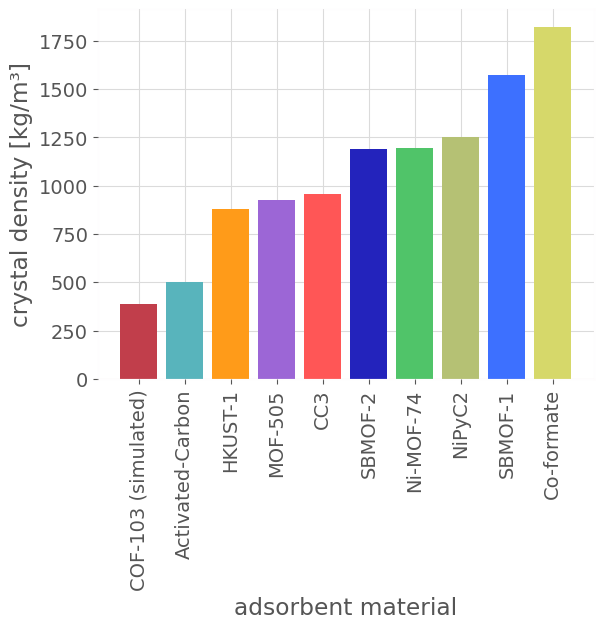

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x000000004B94BC10>, PyObject <matplotlib.axis.XTick object at 0x00000000615BF880>, PyObject <matplotlib.axis.XTick object at 0x0000000063F4F3A0>, PyObject <matplotlib.axis.XTick object at 0x00000000653F2A90>, PyObject <matplotlib.axis.XTick object at 0x000000006AC730A0>, PyObject <matplotlib.axis.XTick object at 0x0000000061B2BE20>, PyObject <matplotlib.axis.XTick object at 0x0000000061B4AA30>, PyObject <matplotlib.axis.XTick object at 0x0000000064831BE0>, PyObject <matplotlib.axis.XTick object at 0x000000006482A760>, PyObject <matplotlib.axis.XTick object at 0x0000000063CDAFA0>], PyCall.PyObject[PyObject Text(1, 0, 'COF-103 (simulated)'), PyObject Text(2, 0, 'Activated-Carbon'), PyObject Text(3, 0, 'HKUST-1'), PyObject Text(4, 0, 'MOF-505'), PyObject Text(5, 0, 'CC3'), PyObject Text(6, 0, 'SBMOF-2'), PyObject Text(7, 0, 'Ni-MOF-74'), PyObject Text(8, 0, 'NiPyC2'), PyObject Text(9, 0, 'SBMOF-1'), PyObject Text(10, 0, 'Co-forma

In [86]:
figure()
xlabel("adsorbent material")
ylabel("crystal density [kg/m³]")
bar(1:nrow(df_ρ_crystal), df_ρ_crystal[:, :ρ], color=df_ρ_crystal[:, :color])
xticks(1:nrow(df_ρ_crystal), df_ρ_crystal[:, :xtal], rotation="vertical")
#savefig("figures/material_densities.png")

### langmuir density correlations

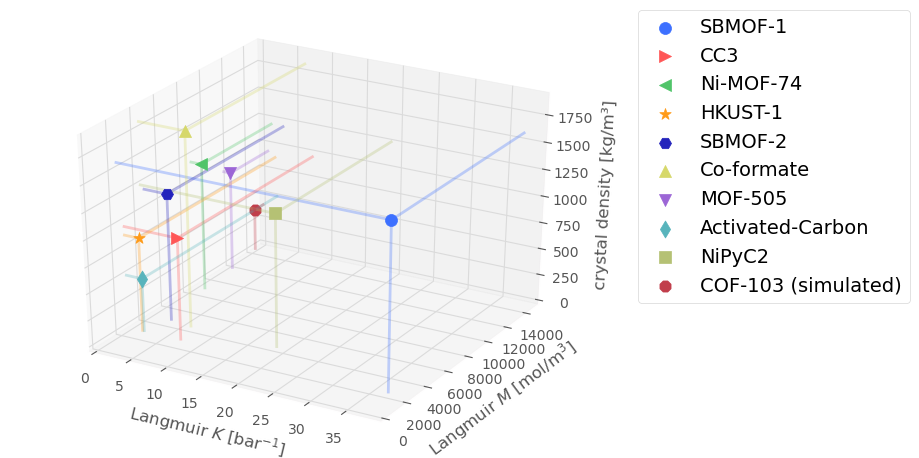

sys:1: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
sys:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


PyObject <matplotlib.legend.Legend object at 0x000000007FBD31F0>

In [87]:
figure()
title("material Space")

for row in eachrow(df_crystal)
    x = [row[:K_inv_bar], row[:M_mol_m3], row[:ρ_kg_m3]]
    scatter3D(x..., 
        label=row[:xtal], marker=xtal_to_marker[row[:xtal]], s=75, 
        color=xtal_to_color[row[:xtal]]
#        color=row[:xtal] == "COF-103 (simulated)" ? "none" : xtal_to_color[row[:xtal]]
              )
end 

for row in eachrow(df_crystal)
    x = [row[:K_inv_bar], row[:M_mol_m3], row[:ρ_kg_m3]]
    for k = 1:3
        x_projected = copy(x)
        if k == 2
            x_projected[k] = 15000
        else
            x_projected[k] = 0
        end
        plot(
            [x_projected[1], x[1]], 
            [x_projected[2], x[2]], 
            [x_projected[3], x[3]], 
            color=xtal_to_color[row[:xtal]], alpha=0.3
            )
    end
end

xlabel(L"Langmuir $K$ [bar$^{-1}$]", labelpad=6, fontsize=12)
ylabel(L"Langmuir $M$ [mol/m$^3$]", labelpad=6, fontsize=12)
zlabel("crystal density [kg/m³]", labelpad=6, fontsize=12)

tick_params(labelsize=10)
tight_layout()
ylim(0.0, 15000)
xlim(left=0.0)
zlim(bottom=0.0)
lgd = legend(bbox_to_anchor=(1.05, 1), borderaxespad=0, fontsize=14)

#savefig("figures/material_space.png")

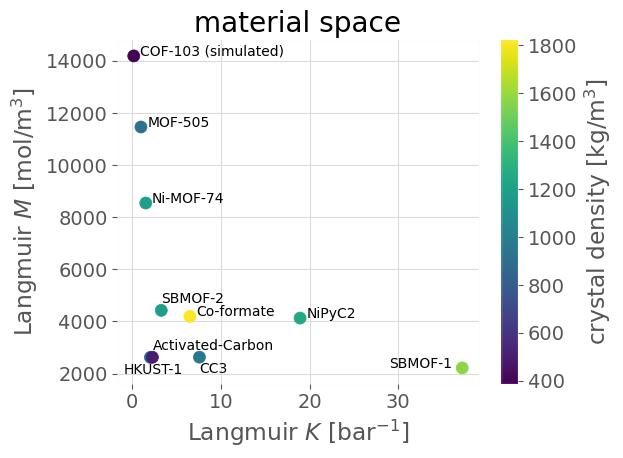

In [88]:
K = df_crystal[:, :K_inv_bar]
M = df_crystal[:, :M_mol_m3]

figure()
title("material space")
scatter(K, M, c=df_crystal[:, :ρ_kg_m3], marker="o", s=75, clip_on=false)

xtal_to_text_pos = Dict(crystal => [0.7, 0.7] for crystal in crystal_names)
xtal_to_text_pos["SBMOF-1"] = [-8.3, 0]
xtal_to_text_pos["SBMOF-2"] = [0, 300]
xtal_to_text_pos["FMOF-Cu"] = [-1, 500]
xtal_to_text_pos["Activated-Carbon"] = [0, 270]
xtal_to_text_pos["HKUST-1"] = [-3, -650]
xtal_to_text_pos["CC3"] = [0, -600]

for i = 1:length(crystal_names)
    text(
        K[i]+xtal_to_text_pos[crystal_names[i]][1], M[i]+xtal_to_text_pos[crystal_names[i]][2],
        crystal_names[i], fontsize=10
        )
end

xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel(L"Langmuir $M$ [mol/m$^3$]")
colorbar(label=L"crystal density [kg/m$^3$]")
tight_layout()
#savefig("figures/material_space_color_bar.png")

## viz Langmuir fits

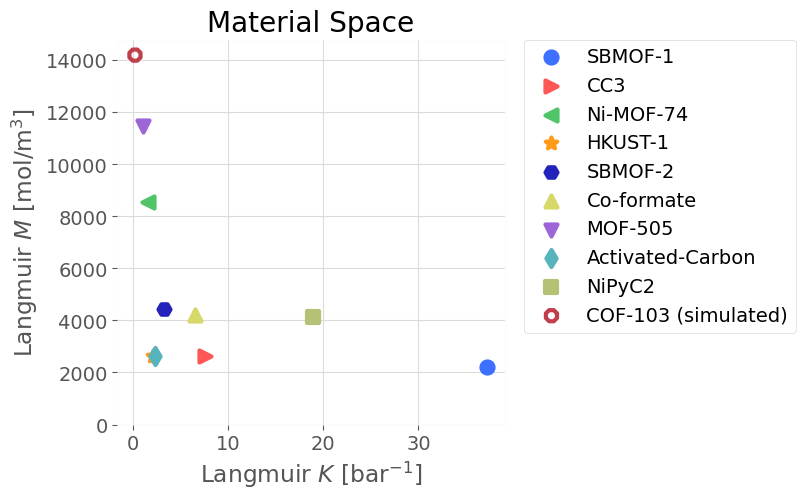

PyObject <matplotlib.legend.Legend object at 0x00000000842B47C0>

In [89]:
figure(figsize=(5,5))
title("Material Space")
for xtal in crystal_names
    scatter(xtal_to_K[xtal], xtal_to_M[xtal], 
        label=xtal, marker=xtal_to_marker[xtal], s=75, clip_on=false, 
        color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal], 
        edgecolor=xtal_to_color[xtal], lw=3)
end
xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel(L"Langmuir $M$ [mol/m$^3$]")
ylim(ymin=0.0)
# xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
#savefig("figures/material_space_langmuir.png")

In [124]:
function plot_xtal_langmuir_fit(xtal::String, max_pressure::Float64)
    
    # fitting plot
    figure()
    xlabel(L"Pressure, $P$ [bar]")
    ylabel("ρₓₑ [mol / m\$^3\$]")
    title(xtal)
    label="experiment"
    if xtal == "COF-103 (simulated)"
        label="simulation"
    end
    scatter(xe_isotherms[xtal][:, common_pressure_units], xe_isotherms[xtal][:, common_loading_units],
        color=xtal_to_color[xtal], label=label)
    
    # Langmuir fit
    pressure_low = range(0.0, stop=max_pressure, length=500) # check with COF-103
    ρ_langmuir = (params_langmuir[xtal]["M"] .* params_langmuir[xtal]["K"] .* pressure_low) ./ (
                    1 .+ params_langmuir[xtal]["K"] * pressure_low)
    plot(pressure_low, ρ_langmuir, color=xtal_to_color[xtal], label="Langmuir fit")
    
    # bulk gas density
    if max_pressure < 1.5
        plot(df_low_p_xe_data[:, Symbol("Pressure (bar)")], df_low_p_xe_data[:, Symbol("Density (mol/m³)")], 
            label="bulk gas", linestyle="--", color="gray")
    else 
        max_index = findfirst(df_xe_data[:, Symbol("Pressure (bar)")] .> max_pressure) # find the index of the max pressure in the dataframe
        plot(df_xe_data[1:max_index, Symbol("Pressure (bar)")], df_xe_data[1:max_index, Symbol("Density (mol/m³)")], 
            label="bulk gas", linestyle="--", color="gray")
    end
    
    grid("on")
    legend()
    tight_layout()
    
     if max_pressure < 1.5
        xlim(xmax=1.05)
        savefig(string("figures/langmuir/low_P_langmuir_fit_", xtal, ".png"))
     else
        savefig(string("figures/langmuir/high_P_langmuir_fit_", xtal, ".png"))
     end

end

plot_xtal_langmuir_fit (generic function with 1 method)

### Low pressure fit

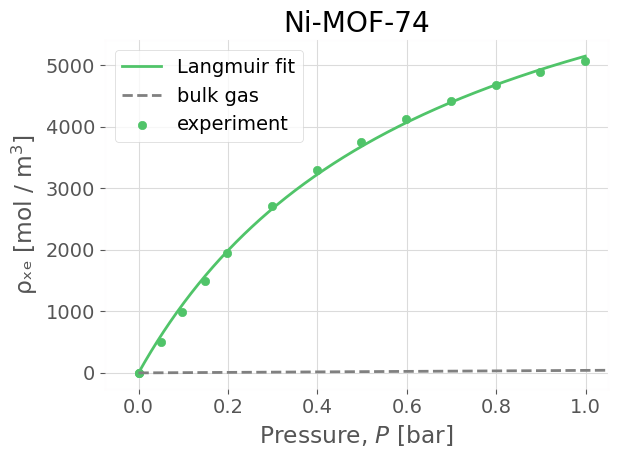

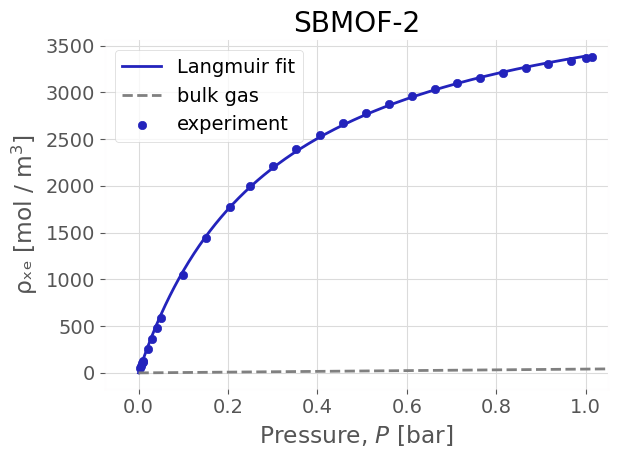

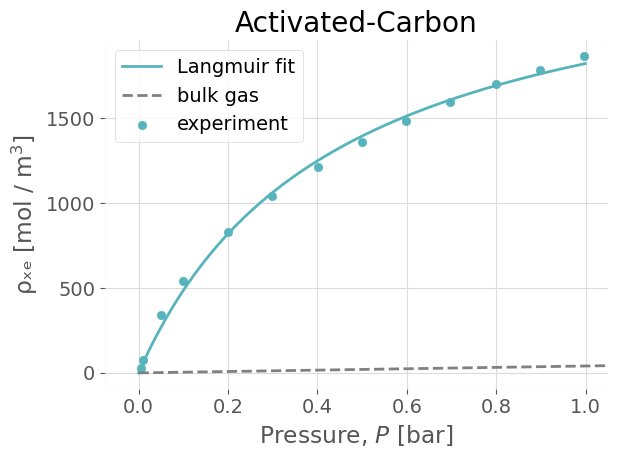

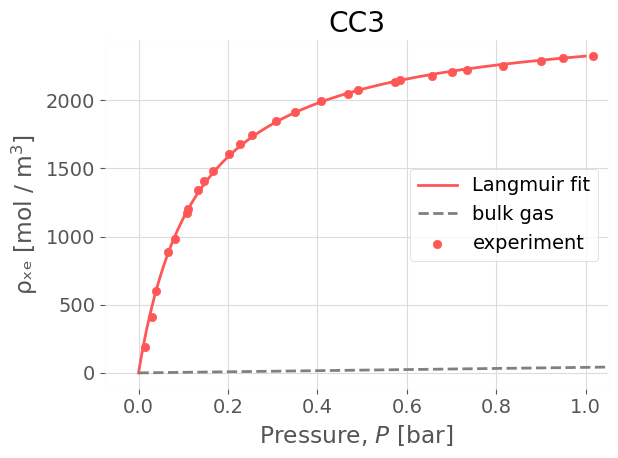

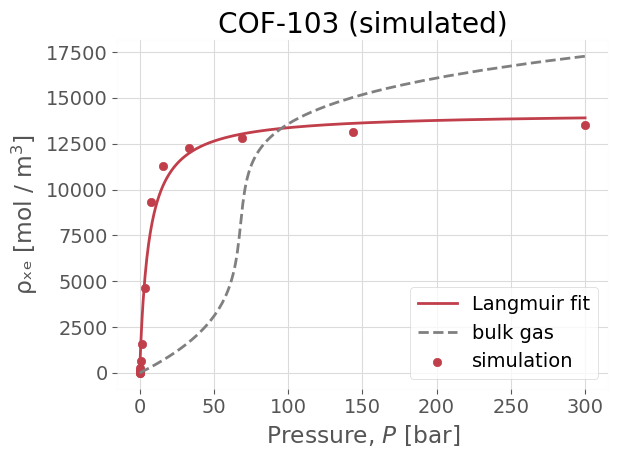

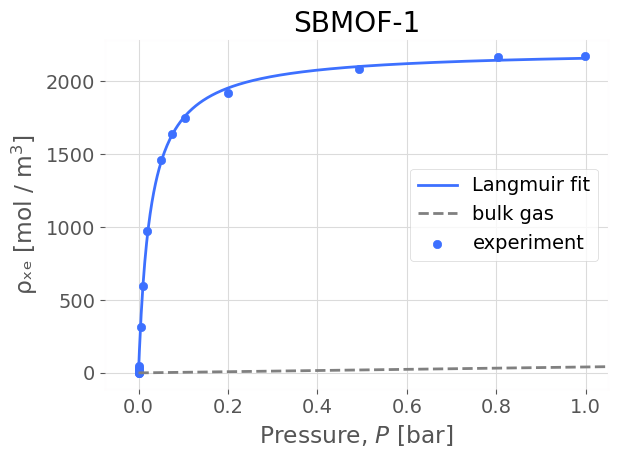

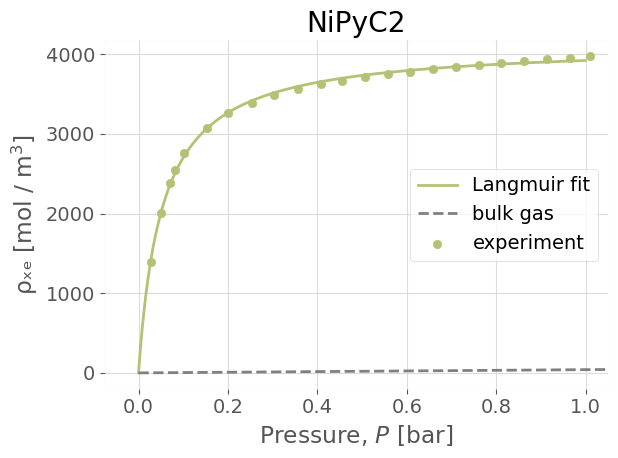

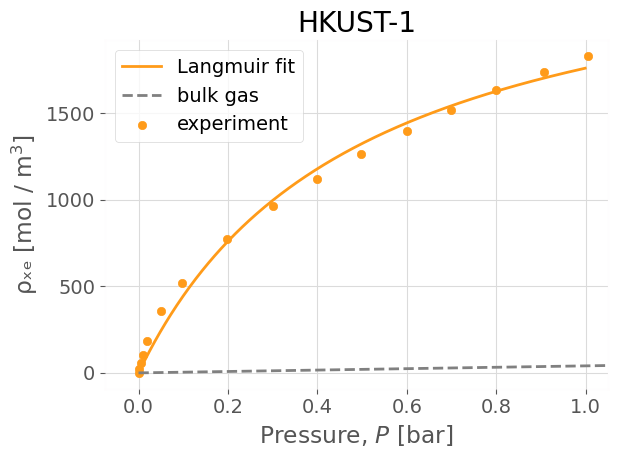

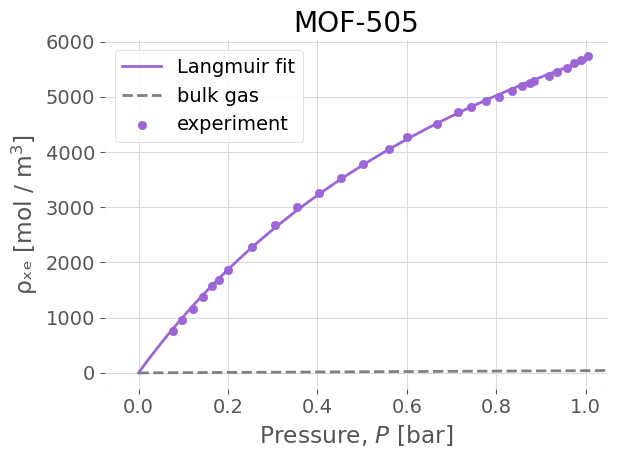

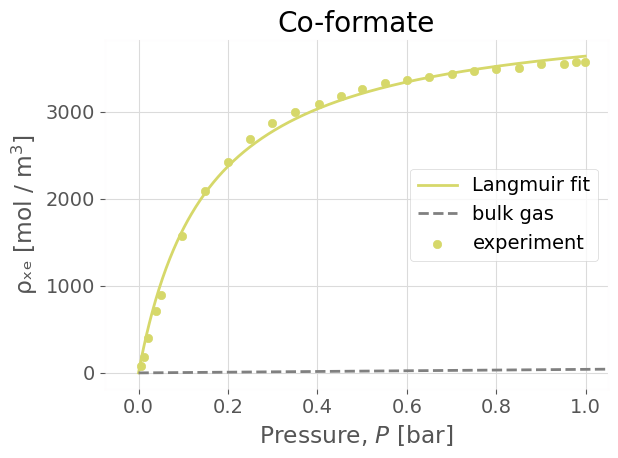

In [125]:
for xtal in keys(xe_isotherms)
    if xtal == "COF-103 (simulated)"
        plot_xtal_langmuir_fit(xtal, 299.999)
        savefig(string("figures/langmuir/low_P_langmuir_fit_", xtal, ".png"))        
    else
        plot_xtal_langmuir_fit(xtal, 0.999)
    end
end

### High pressure fit

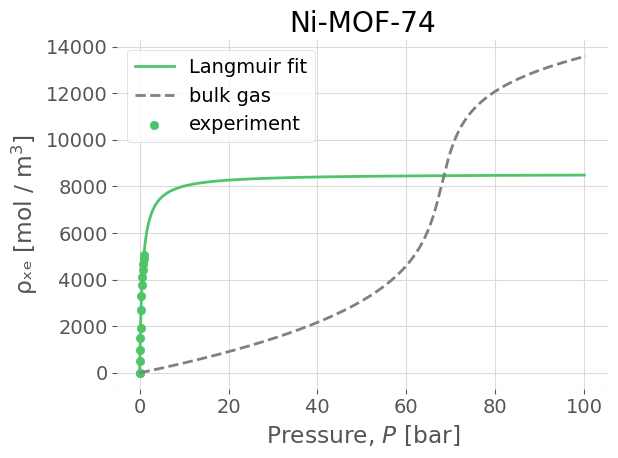

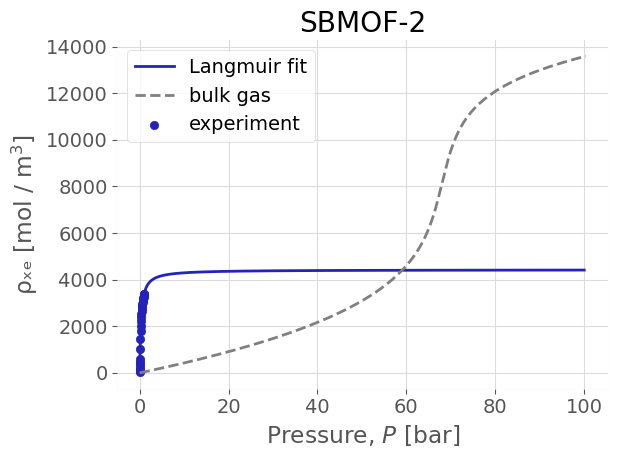

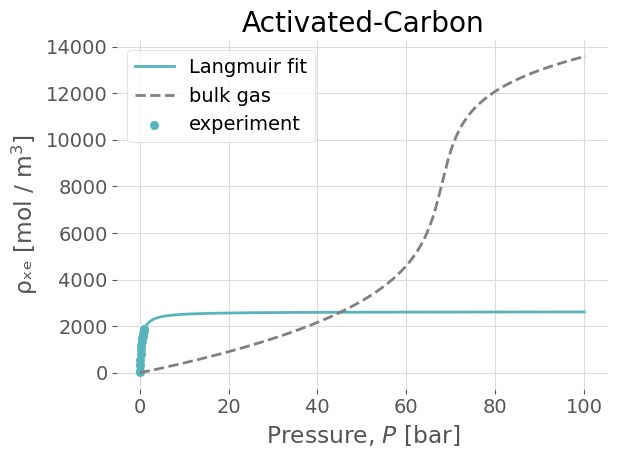

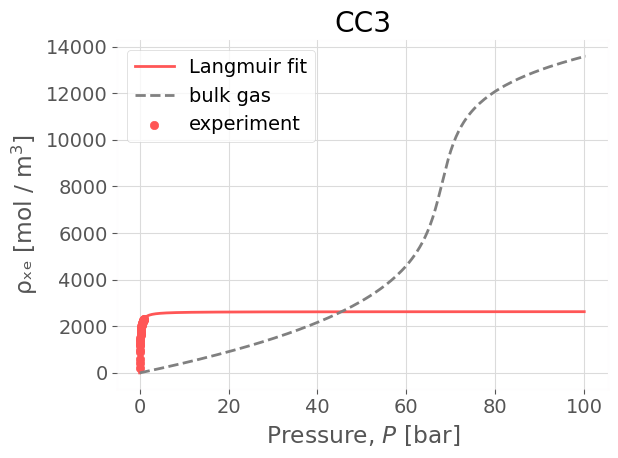

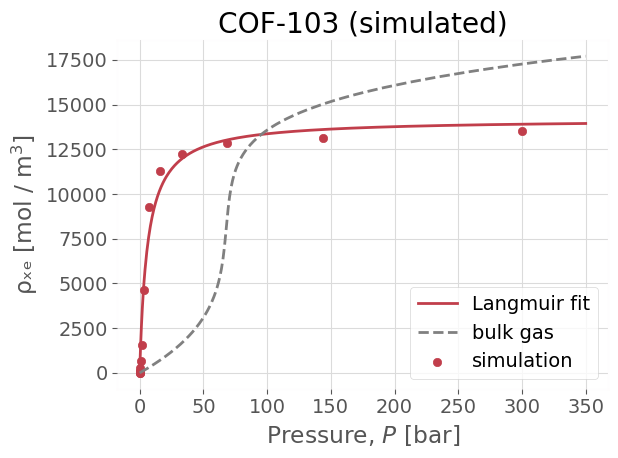

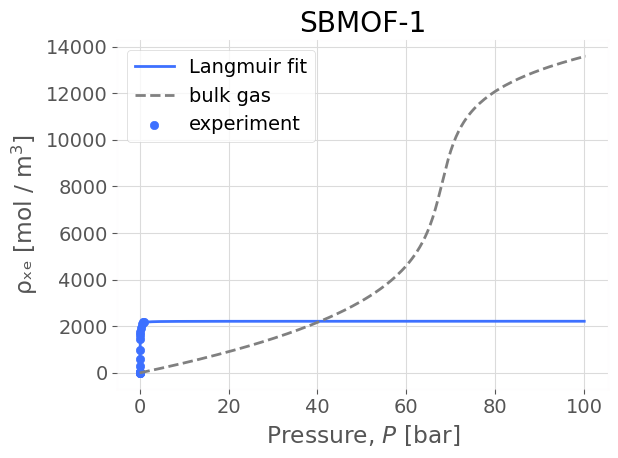

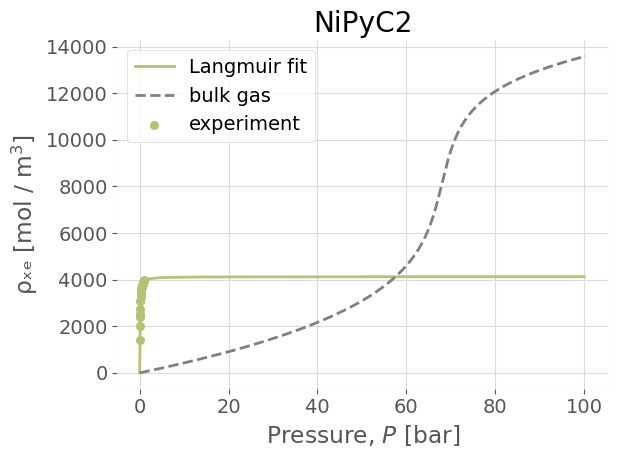

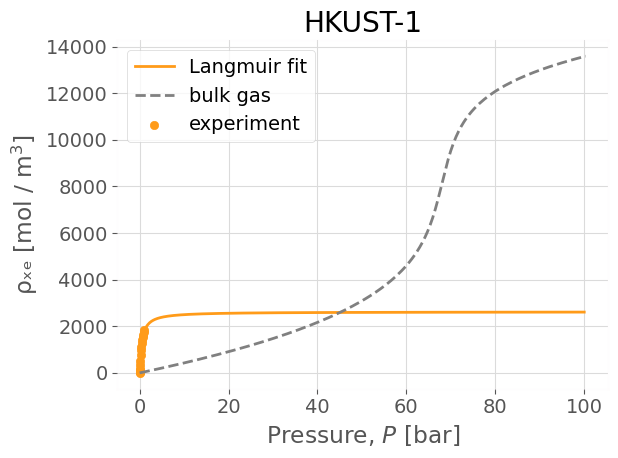

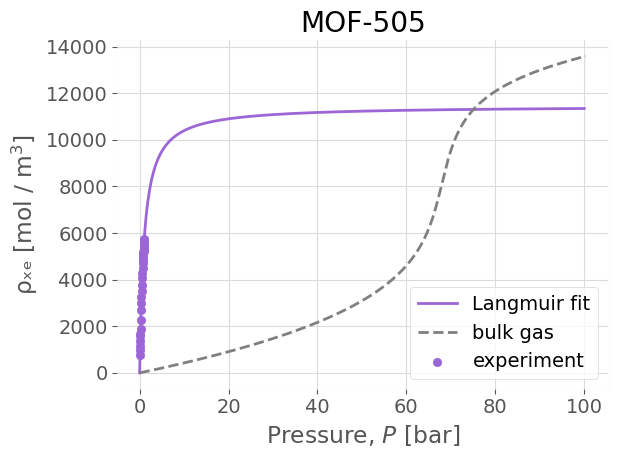

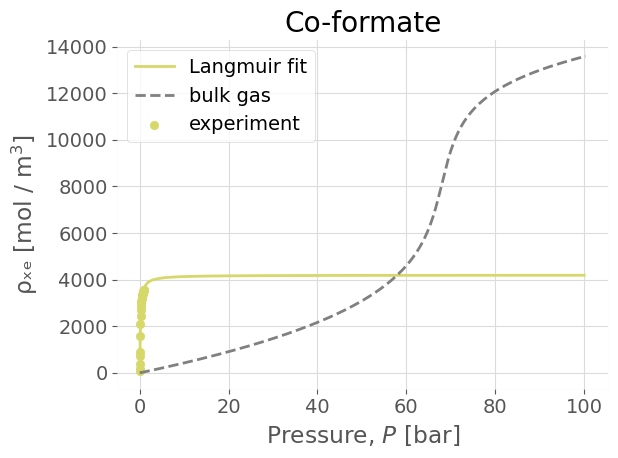

In [126]:
for xtal in keys(xe_isotherms)
    if xtal == "COF-103 (simulated)"
        plot_xtal_langmuir_fit(xtal, 349.999)
    else
        plot_xtal_langmuir_fit(xtal, 100.0)
    end
end